## Dataset Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Yoga/DATASET"

TEST  TRAIN


In [ ]:
!ls "/content/drive/My Drive/Yoga/DATASET/TRAIN"


Downdog  Goddess  Mountain  Plank  Tree  Warrior


In [ ]:
import os

train_dir = "/content/drive/My Drive/Yoga/DATASET/TRAIN"

if os.path.exists(train_dir):
    print("Path exists:", train_dir)
else:
    print("Path does NOT exist:", train_dir)

Path exists: /content/drive/My Drive/Yoga/DATASET/TRAIN


In [ ]:
import os

train_dir = "/content/drive/My Drive/Yoga/DATASET/TRAIN"

try:
    class_names = sorted(os.listdir(train_dir))
    print(f"Classes: {class_names}")
    print(f"Total Number of Classes: {len(class_names)}")
except Exception as e:
    print(f"Error: {e}")


Classes: ['Downdog', 'Goddess', 'Mountain', 'Plank', 'Tree', 'Warrior']
Total Number of Classes: 6


## Import the Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import tensorflow as tf
import os
import hashlib
import shutil
import cv2
import warnings

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model
from keras.callbacks import Callback, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from PIL import Image, ImageFile
from collections import defaultdict

# %matplotlib inline
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Define Reusable Function

In [ ]:
def image_path(image_name):
    return os.path.join(images_dir, image_name)

def model_path(model_name):
    return os.path.join(model_dir, model_name)

def plot_metric(history):
    """Plots training and validation accuracy/loss curves."""
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)

    # Plot accuracy
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot loss
    plt.figure()
    plt.plot(epochs, train_loss,label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend(["train_loss", 'val_loss'])

    plt.show()

## Step 2: Data Preprocessing

### 2.1 Set Up Directories

In [ ]:
base_dir = "/content/drive/My Drive/Yoga"
train_dir = os.path.join(base_dir, "DATASET", "TRAIN")
test_dir = os.path.join(base_dir, "DATASET", "TEST")

In [ ]:
import os

train_dir = "/content/drive/My Drive/Yoga/DATASET/TRAIN"

# Get class names sorted alphabetically
class_names = sorted(os.listdir(train_dir))

# Count number of classes
no_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Total Number of Classes: {no_classes}")


Classes: ['Downdog', 'Goddess', 'Mountain', 'Plank', 'Tree', 'Warrior']
Total Number of Classes: 6


In [ ]:
class_dis_tr = [len(os.listdir(train_dir + f"/{name}")) for name in class_names]
print(class_dis_tr)

class_dis_te = [len(os.listdir(test_dir + f"/{name}")) for name in class_names]
print(class_dis_te)

[223, 180, 100, 266, 160, 252]
[97, 80, 50, 115, 69, 109]


## 2.2 Data Visualization

In [ ]:
#Bar Plot – Class Distribution
def plot_class_distribution(directory, title):
    """Plots the number of images per class."""
    class_counts = {class_name: len(os.listdir(os.path.join(directory, class_name)))
                    for class_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, class_name))}

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.xticks(rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.show()

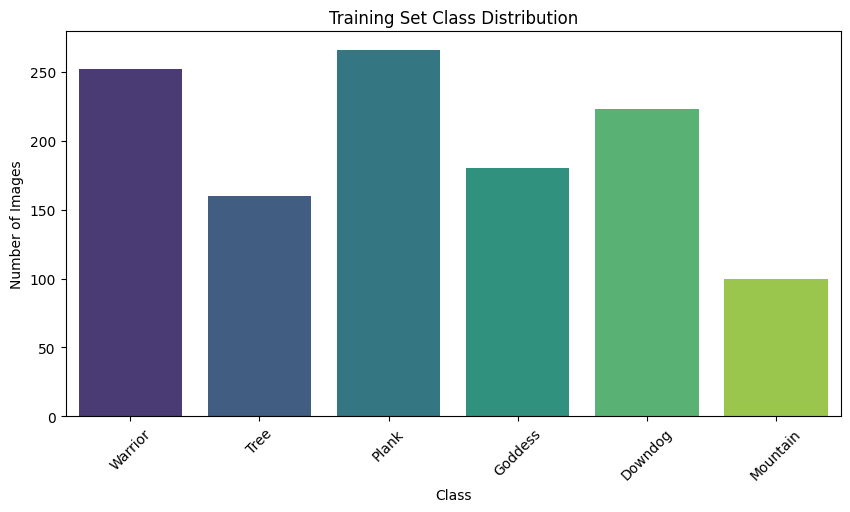

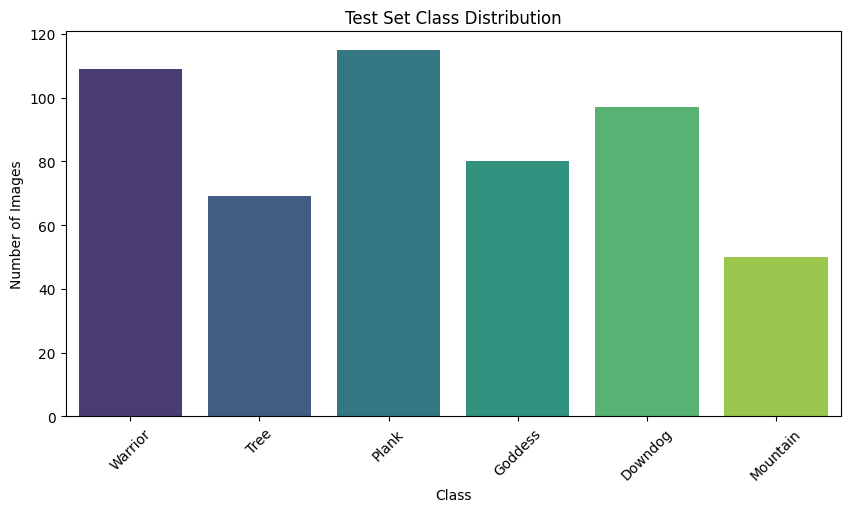

In [ ]:
plot_class_distribution(train_dir, "Training Set Class Distribution")
plot_class_distribution(test_dir, "Test Set Class Distribution")

In [ ]:
# Pie Chart – Class Distribution
def plot_class_pie_chart(directory, title):
    class_counts = {class_name: len(os.listdir(os.path.join(directory, class_name)))
                    for class_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, class_name))}

    plt.figure(figsize=(8, 8))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=sns.color_palette("viridis", len(class_counts)))
    plt.title(title)
    plt.show()


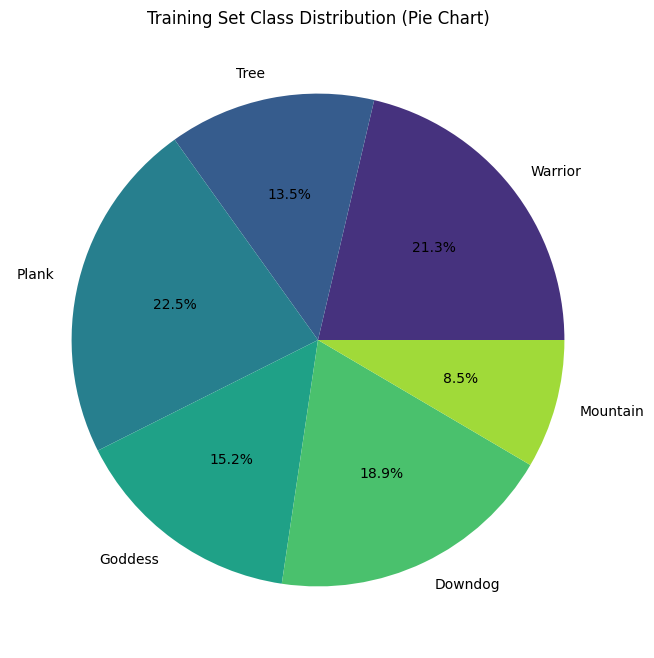

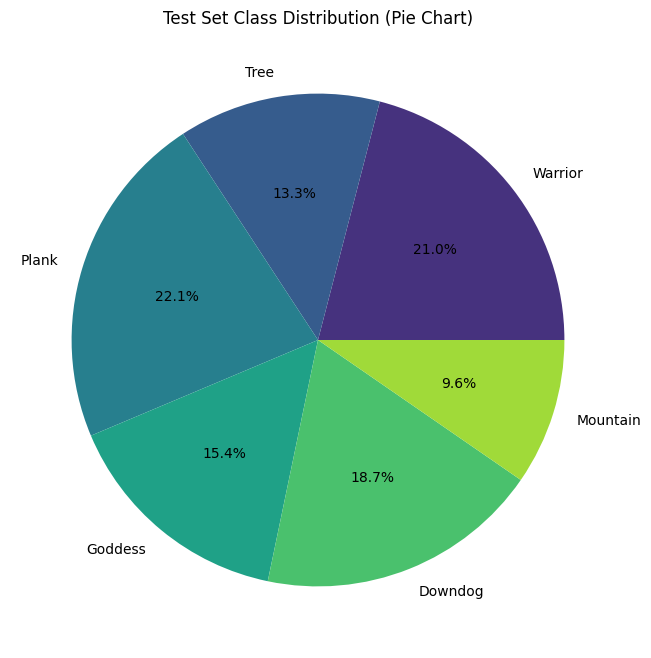

In [ ]:
plot_class_pie_chart(train_dir, "Training Set Class Distribution (Pie Chart)")
plot_class_pie_chart(test_dir, "Test Set Class Distribution (Pie Chart)")

### 2.4 Data augmentation

In [ ]:
train_datagen = IDG(rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                width_shift_range=0.1,
                height_shift_range=0.1,
                rotation_range=30,
                brightness_range=[0.8, 1.3],
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Standard VGG16 preprocessing
                )

test_datagen = IDG(rescale = 1./255 )     # Rescale the pixel values to [0,1]


In [ ]:
# Create a generator for training data from a directory
train_generator =  train_datagen.flow_from_directory(train_dir,                 # Directory path for training data
                                                    target_size = (224,224),    # Reshape images to the specified dimensions
                                                    color_mode = 'rgb',         # Color mode set to RGB
                                                    class_mode = 'categorical', # Use categorical labels
                                                    batch_size = 32     # Set the batch size for training
                                                     )

# Create a generator for validation data from a directory
validation_generator  = test_datagen.flow_from_directory(test_dir,              # Directory path for testing data
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical'
                                                 )

Found 1180 images belonging to 6 classes.
Found 520 images belonging to 6 classes.


In [ ]:
print("number of images", train_generator.samples)
print("number of class", len(train_generator.class_indices))
print("number of images in the classes", train_generator.samples / len(train_generator.class_indices))

print("number of images", validation_generator.samples)
print("number of class", len(validation_generator.class_indices))
print("number of images in the classes", validation_generator.samples / len(validation_generator.class_indices))

number of images 1180
number of class 6
number of images in the classes 196.66666666666666
number of images 520
number of class 6
number of images in the classes 86.66666666666667


## Step 3: Model Creation

### 3.1 Model Creation

In [ ]:
model_name = "Yoga-Pose-Classification"

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers[:10]:
    layer.trainable = False


In [ ]:
def create_baseline():
    model_vgg = Sequential(name="Custom_VGG16_Model")
    model_vgg.add(base_model)

    model_vgg.add(Flatten(name='flattened'))
    model_vgg.add(Dropout(0.5, name='dropout1'))
    model_vgg.add(Dense(96, activation='relu', kernel_regularizer=l2(0.0003), name='dense1'))
    model_vgg.add(Dropout(0.2, name='dropout2'))
    model_vgg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0003), name='dense2'))
    model_vgg.add(Dense(no_classes, activation='softmax', name='predictions'))

    return model_vgg

In [ ]:
model_vgg = create_baseline()

In [ ]:
model_vgg.build()

## Step 4: Compile Model

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model_vgg = create_baseline()
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


## Step 5: Define Callbacks and Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)


In [ ]:
cbs = [early_stopping, reduce_lr]

## Step 6: Model Training

In [ ]:
history = model_vgg.fit(train_generator,
          epochs=25,
          validation_data=validation_generator,
          callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2362 - loss: 1.7383 - val_accuracy: 0.4021 - val_loss: 1.5993 - learning_rate: 1.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2906 - loss: 1.6612 - val_accuracy: 0.5128 - val_loss: 1.4696 - learning_rate: 1.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3057 - loss: 1.6124 - val_accuracy: 0.6340 - val_loss: 1.2919 - learning_rate: 1.0000e-04
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4159 - loss: 1.4683 - val_accuracy: 0.7638 - val_loss: 0.8111 - learning_rate: 1.0000e-04
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4413 - loss: 1.3955 - val_accuracy: 0.8745 - val_loss: 0.5968 - learning_rate: 1.0000e-04
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5251 - loss: 1.2043 - val_accuracy: 0.8638 - val_loss: 0.4806 - learning_rate: 1.0000e-04
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6430 - loss:

## Step 7: Evaluate: Plot the Graphs and Final Accuracy

In [ ]:
plot_metric(history)

NameError: name 'history' is not defined

In [ ]:
train_loss, train_acc = model_vgg.evaluate(train_generator)
test_loss, test_acc   = model_vgg.evaluate(validation_generator)

print(f"Final Train Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {test_acc * 100:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 789ms/step - accuracy: 0.9406 - loss: 0.2795
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step - accuracy: 0.9631 - loss: 0.1893
Final Train Accuracy: 94.63%
Final Validation Accuracy: 95.74%


In [ ]:
model_vgg.save("/content/drive/My Drive/Yoga/6_March_vgg16.h5")

In [ ]:
import os

model_path = "/content/drive/My Drive/Yoga/6_March_vgg16.h5"
if os.path.exists(model_path):
    print("Model saved successfully.")
else:
    print("Error: Model not saved.")

Model saved successfully.


## Step 8: Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


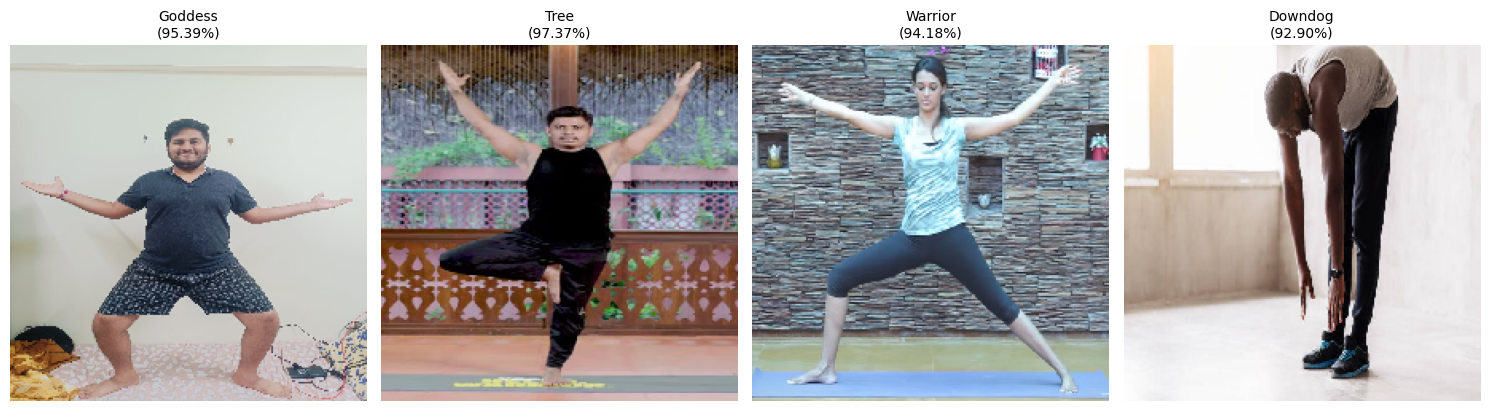

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os


model_path = "/content/drive/My Drive/Yoga/6_March_vgg16.h5"
model = tf.keras.models.load_model(model_path)


train_dir = "/content/drive/My Drive/Yoga/DATASET/TRAIN"
class_names = sorted(os.listdir(train_dir))


def predict_yoga_poses(image_paths):
    """Loads multiple images, preprocesses them, and predicts yoga poses side by side."""
    try:
        fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

        if len(image_paths) == 1:
            axes = [axes]

        for ax, image_path in zip(axes, image_paths):
            # Load image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalize

            # Make prediction
            predictions = model.predict(img_array)
            predicted_class_index = np.argmax(predictions[0])
            predicted_class = class_names[predicted_class_index]
            confidence = predictions[0][predicted_class_index] * 100

            # Display image and prediction
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{predicted_class}\n({confidence:.2f}%)", fontsize=10)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")


# Example usage with multiple images
image_paths = [
    "/content/drive/My Drive/Testing/Goddess_Pose.jpg",
    "/content/drive/My Drive/Testing/Tree_Pose.png",
    "/content/drive/My Drive/Testing/Warrior_Pose_1.png",
    "/content/drive/My Drive/Testing/Downdog_Pose_2.jpg",
]

predict_yoga_poses(image_paths)